In [13]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess


pd.set_option("display.max_columns",30)

In [3]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan
        if var_name == "mcp9808": 
            series = series.replace(0.00, np.nan)

            

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}

In [37]:
def rename_variables(ds):
    variable_mapping = {
        'var167': 't2m',      # 2 metre temperature
        'var228': 'tp',       # Total precipitation
        'var165': 'u10',      # 10 metre U wind component
        'var166': 'v10',      # 10 metre V wind component
        # Add other mappings as needed
    }
    variables_to_rename = {var: new_var for var, new_var in variable_mapping.items() if var in ds.variables}
    ds = ds.rename(variables_to_rename)
    return ds

def scale_variables(ds):
    ds["t2m"].values = ds["t2m"].values - 273.15
    ds["tp"].values = ds["tp"].values * 1000
    u10 = ds['u10']
    v10 = ds['v10']
    wind_speed = np.sqrt(u10 ** 2 + v10 ** 2)
    ds['wind_speed'] = wind_speed
    return ds

def convert_grib_to_nc( source_path):
    nc_copied_path = "converted_" + source_path 
    cdo_command = f"cdo -f nc copy {(source_path)} {nc_copied_path}"
    subprocess.run(cdo_command, shell=True, check=True)
    assert os.path.exists(nc_copied_path), "Conversion failed"

    # Open the NetCDF file and rename variables
    ds = xr.open_dataset(nc_copied_path)
    ds = rename_variables(ds)
    ds = scale_variables(ds)
    ds.to_netcdf(nc_copied_path)

# Events

## Vienna

In [39]:
convert_grib_to_nc("era5_data/era5_vienna_events.nc")


In [87]:
vienna_er5 = xr.open_dataset("converted_era5_data/era5_vienna_events.nc")
vienna_er5

<xarray.Dataset> Size: 8MB
Dimensions:     (time: 5016, lon: 9, lat: 9)
Coordinates:
  * time        (time) datetime64[ns] 40kB 2017-10-15 ... 2018-05-11T23:00:00
  * lon         (lon) float64 72B 15.36 15.61 15.86 16.11 ... 16.86 17.11 17.36
  * lat         (lat) float64 72B 49.23 48.98 48.73 48.48 ... 47.73 47.48 47.23
Data variables:
    t2m         (time, lat, lon) float32 2MB ...
    tp          (time, lat, lon) float32 2MB ...
    u10         (time, lat, lon) float32 2MB ...
    v10         (time, lat, lon) float32 2MB ...
    wind_speed  (time, lat, lon) float32 2MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Oct 18 17:32:46 2024: cdo -f nc copy era5_data/era5_vie...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [49]:
print("Highest precip. value in ERA5:",vienna_er5.tp.values.max())
print("Highest temp. value in ERA5:",vienna_er5.t2m.values.max())
print("Highest wind speed value in ERA5:",vienna_er5.wind_speed.values.max())

Highest precip. value in ERA5: 4.7005415
Highest temp. value in ERA5: 29.240753
Highest wind speed value in ERA5: 13.629203


In [42]:
vienna_processed_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0)
vienna_processed_df.index = pd.to_datetime(vienna_processed_df.index, errors='coerce')

vienna_hourly_df = pd.DataFrame()

for var_name in vienna_processed_df.columns:
    hourly_series = vienna_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    vienna_hourly_df[var_name] = hourly_series

No high wind speed event

Precipitation: 
- 18.05.10 12/11 >354l
- 17.10.16 16 > 97l

Temperature: 
- cold: 18.03.01 03/02 <10°
- hot: 17.08.03 14/12/13 >35°

### Temperature

In [73]:
# Event 1

event_1 = pd.Timestamp("2018-03-01 03:00")

# measured -11° in 1 h and the previous hour 312.4l/m2

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = vienna_hourly_df[(vienna_hourly_df.index >= event_1 - time_delta) & (vienna_hourly_df.index <= event_1 + time_delta)]
filtered_minute_df = vienna_processed_df[(vienna_processed_df.index >= event_1 - time_delta) & (vienna_processed_df.index <= event_1 + time_delta)]


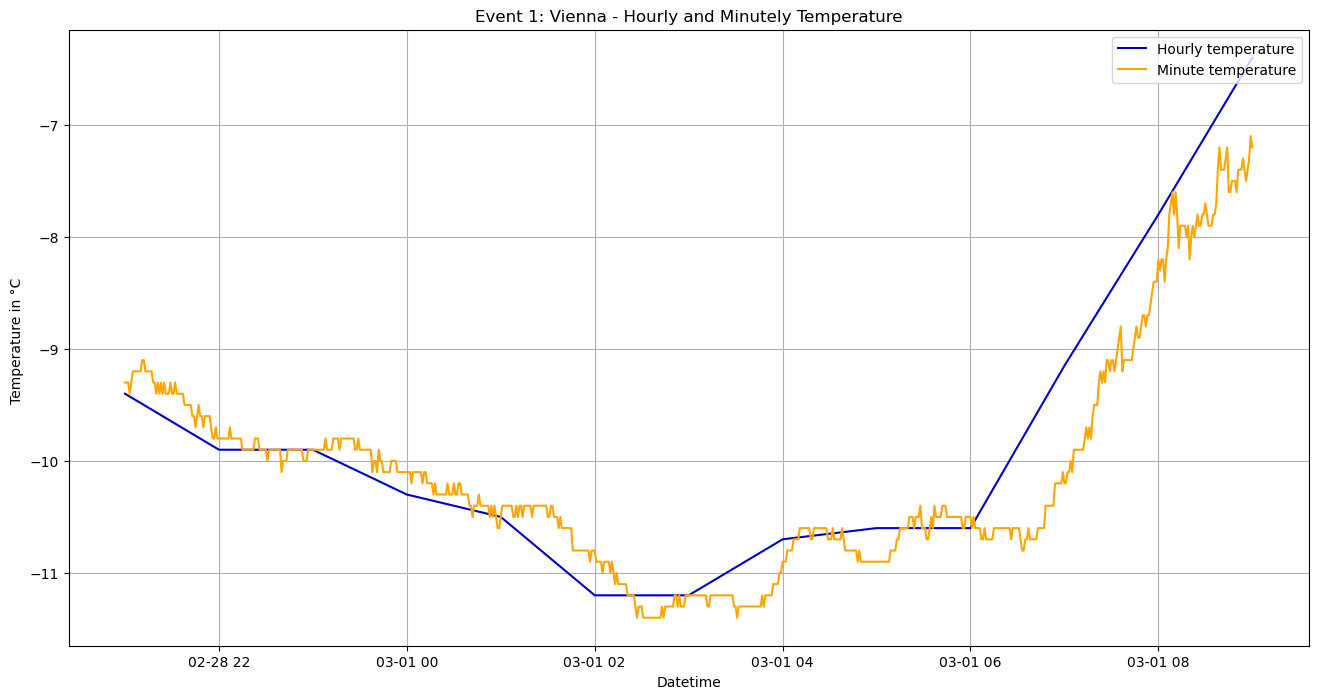

In [76]:
plt.figure(figsize= (16,8)) 
plt.plot(filtered_df["mcp9808"], color='mediumblue', label="Hourly temperature")
plt.plot(filtered_minute_df["mcp9808"], color='orange', label="Minute temperature")
plt.xlabel("Datetime")
plt.ylabel("Temperature in °C ")
plt.title("Event 1: Vienna - Hourly and Minutely Temperature")
plt.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.tick_params(axis='y')
plt.grid(True)


In [77]:
location_tm = vienna_er5.t2m.sel(lat=48.2303 , lon=16.3609, method='nearest')
location_tm = location_tm.sel(time=slice('2018-02-28 23:00', '2018-03-01 09:00'))


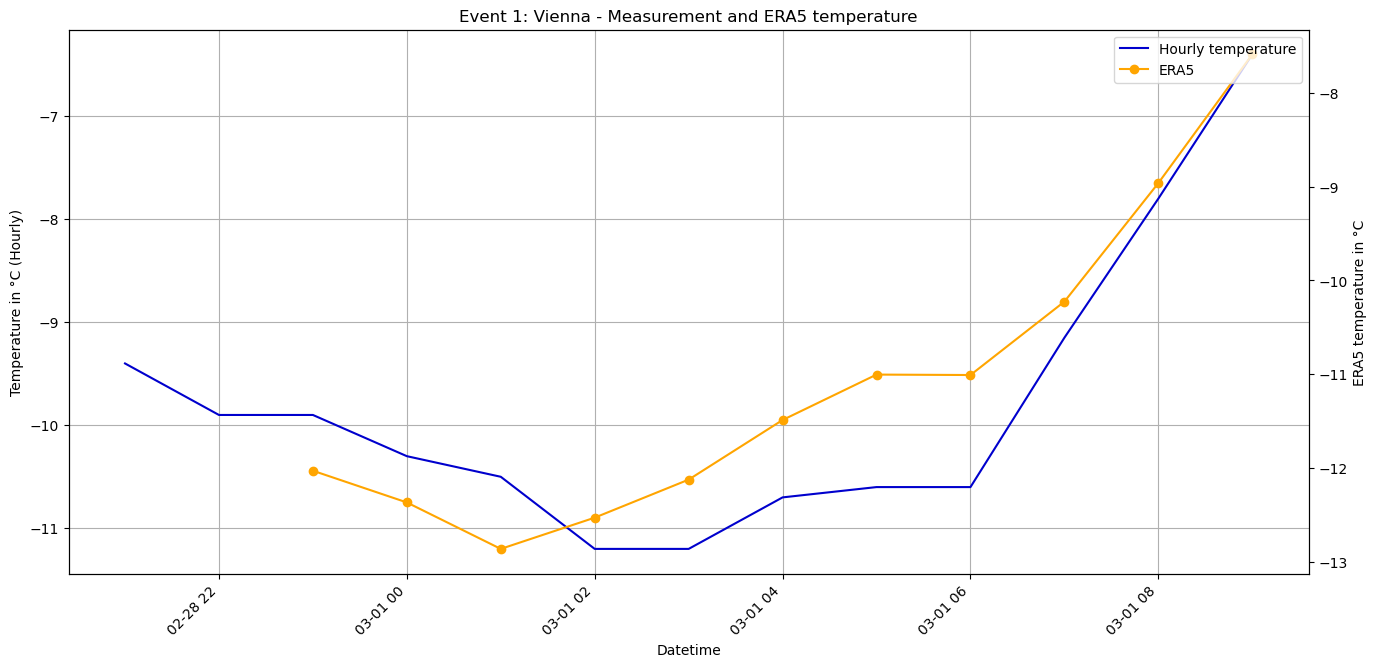

In [78]:
# Convert location_tp to Pandas Series
location_tp_pd = location_tm.to_pandas()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df.index, filtered_df["mcp9808"], color='mediumblue', label="Hourly temperature")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Temperature in °C (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(location_tp_pd.index, location_tp_pd.values, color='orange', label="ERA5", marker='o')
ax2.set_ylabel("ERA5 temperature in °C")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Measurement and ERA5 temperature")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [80]:
# Event 2

event_2 = pd.Timestamp("2017-08-03 13:00")

# measured -11° in 1 h and the previous hour 312.4l/m2

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = vienna_hourly_df[(vienna_hourly_df.index >= event_2 - time_delta) & (vienna_hourly_df.index <= event_2 + time_delta)]
filtered_minute_df = vienna_processed_df[(vienna_processed_df.index >= event_2 - time_delta) & (vienna_processed_df.index <= event_2 + time_delta)]



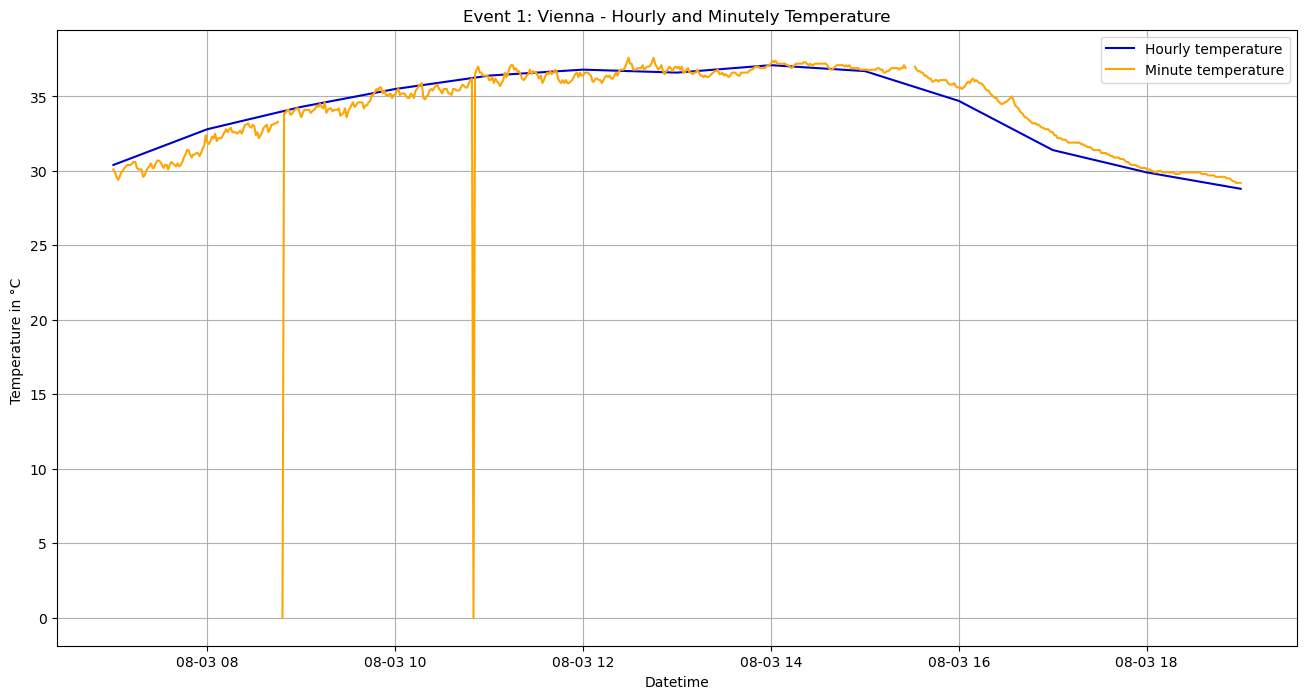

In [81]:
plt.figure(figsize= (16,8)) 
plt.plot(filtered_df["mcp9808"], color='mediumblue', label="Hourly temperature")
plt.plot(filtered_minute_df["mcp9808"], color='orange', label="Minute temperature")
plt.xlabel("Datetime")
plt.ylabel("Temperature in °C ")
plt.title("Event 1: Vienna - Hourly and Minutely Temperature")
plt.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.tick_params(axis='y')
plt.grid(True)


In [90]:
location_tm = vienna_er5.t2m.sel(lat=48.2303 , lon=16.3609, method='nearest')
location_tm = location_tm.sel(time=slice('2017-08-03 07:00', '2017-08-03 19:00'))
location_tm

<xarray.DataArray 't2m' (time: 0)> Size: 0B
[0 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 0B 
    lon      float64 8B 16.36
    lat      float64 8B 48.23
Attributes:
    table:    128

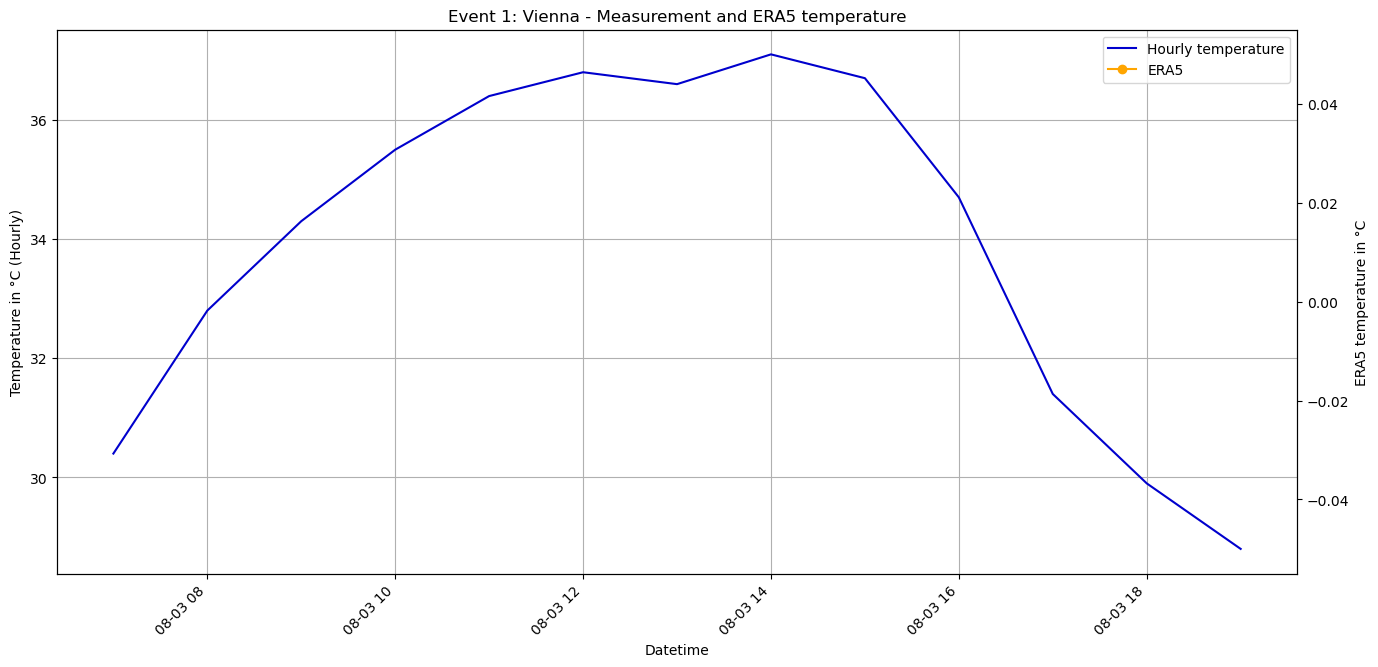

In [89]:
# Convert location_tp to Pandas Series
location_tp_pd = location_tm.to_pandas()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df.index, filtered_df["mcp9808"], color='mediumblue', label="Hourly temperature")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Temperature in °C (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(location_tp_pd.index, location_tp_pd.values, color='orange', label="ERA5", marker='o')
ax2.set_ylabel("ERA5 temperature in °C")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Measurement and ERA5 temperature")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Precipitation

In [43]:
# Event 1

event_1 = pd.Timestamp("2018-05-10 12:00")

# measured 354.4 l/m2 in 1 h and the previous hour 312.4l/m2
# utc in local time 14:00

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = vienna_hourly_df[(vienna_hourly_df.index >= event_1 - time_delta) & (vienna_hourly_df.index <= event_1 + time_delta)]
filtered_minute_df = vienna_processed_df[(vienna_processed_df.index >= event_1 - time_delta) & (vienna_processed_df.index <= event_1 + time_delta)]


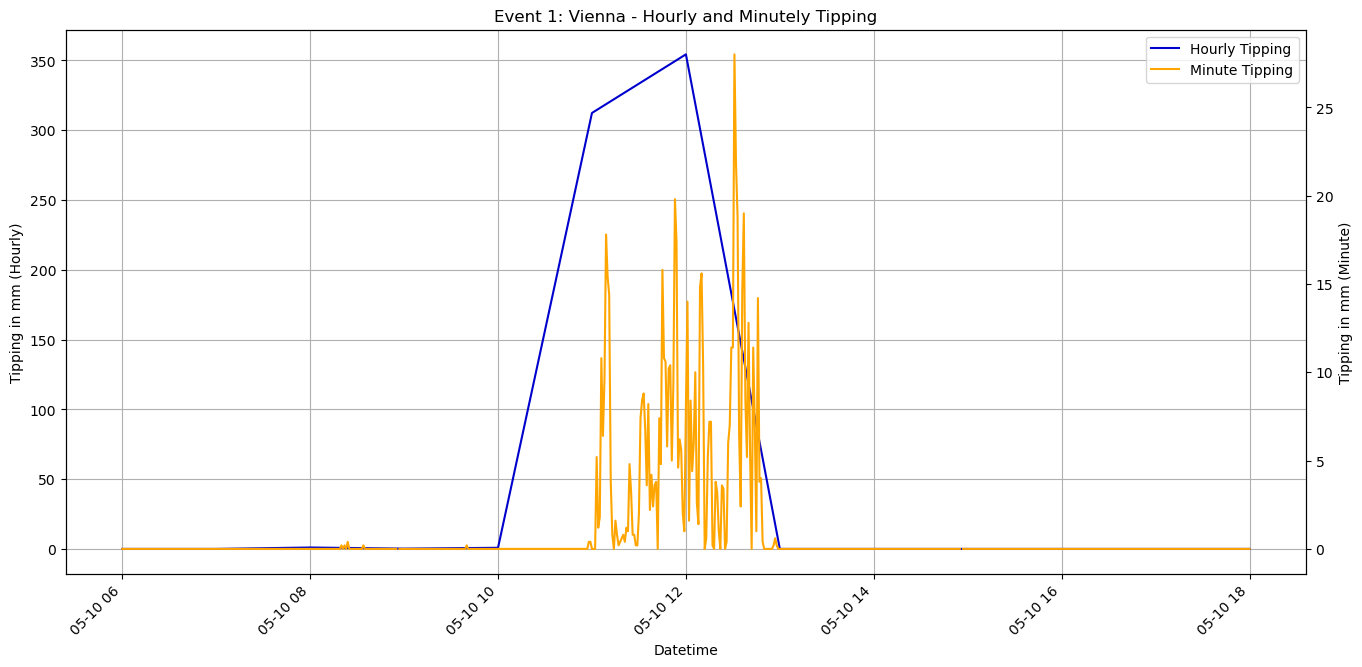

In [64]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_minute_df["tipping"], color='orange', label="Minute Tipping")
ax2.set_ylabel("Tipping in mm (Minute)")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Hourly and Minutely Tipping")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

In [53]:
location_tp = vienna_er5.tp.sel(lat=48.2303 , lon=16.3609, method='nearest')
location_tp = location_tp.sel(time=slice('2018-05-10 06:00', '2018-05-10 18:00'))


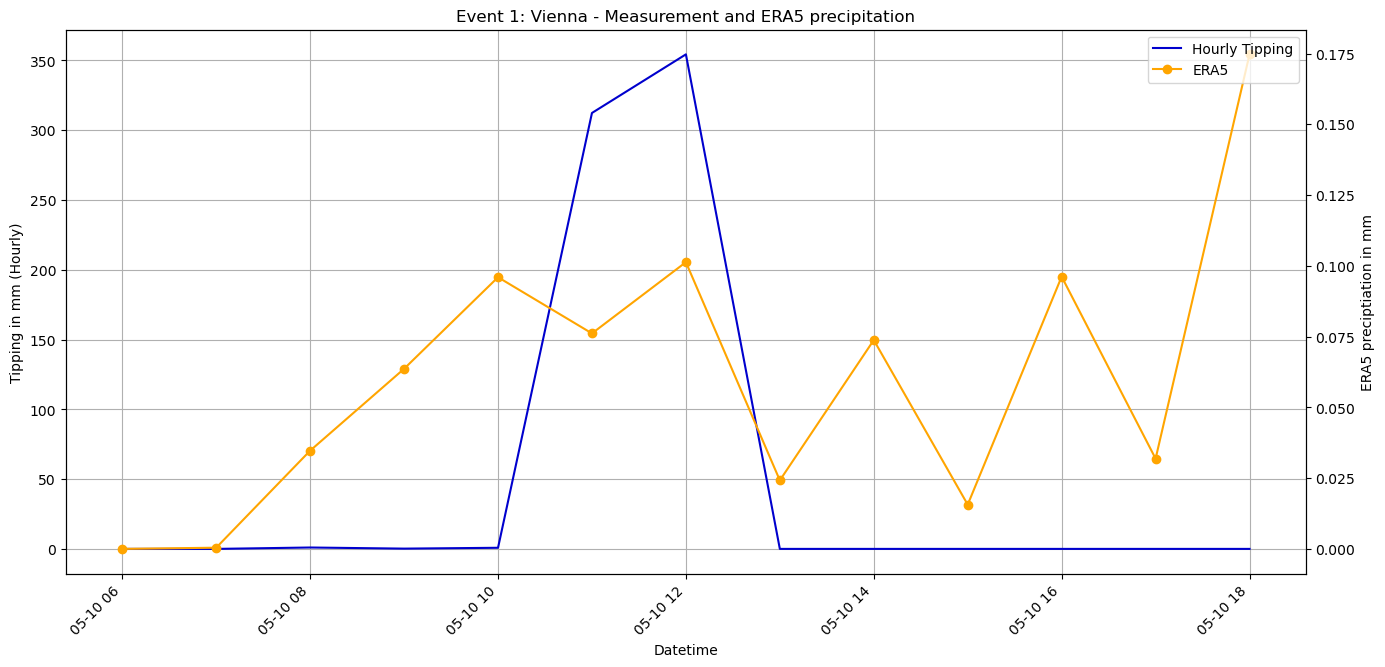

In [63]:
# Convert location_tp to Pandas Series
location_tp_pd = location_tp.to_pandas()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df.index, filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(location_tp_pd.index, location_tp_pd.values, color='orange', label="ERA5", marker='o')
ax2.set_ylabel("ERA5 preciptiation in mm")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Measurement and ERA5 precipitation")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

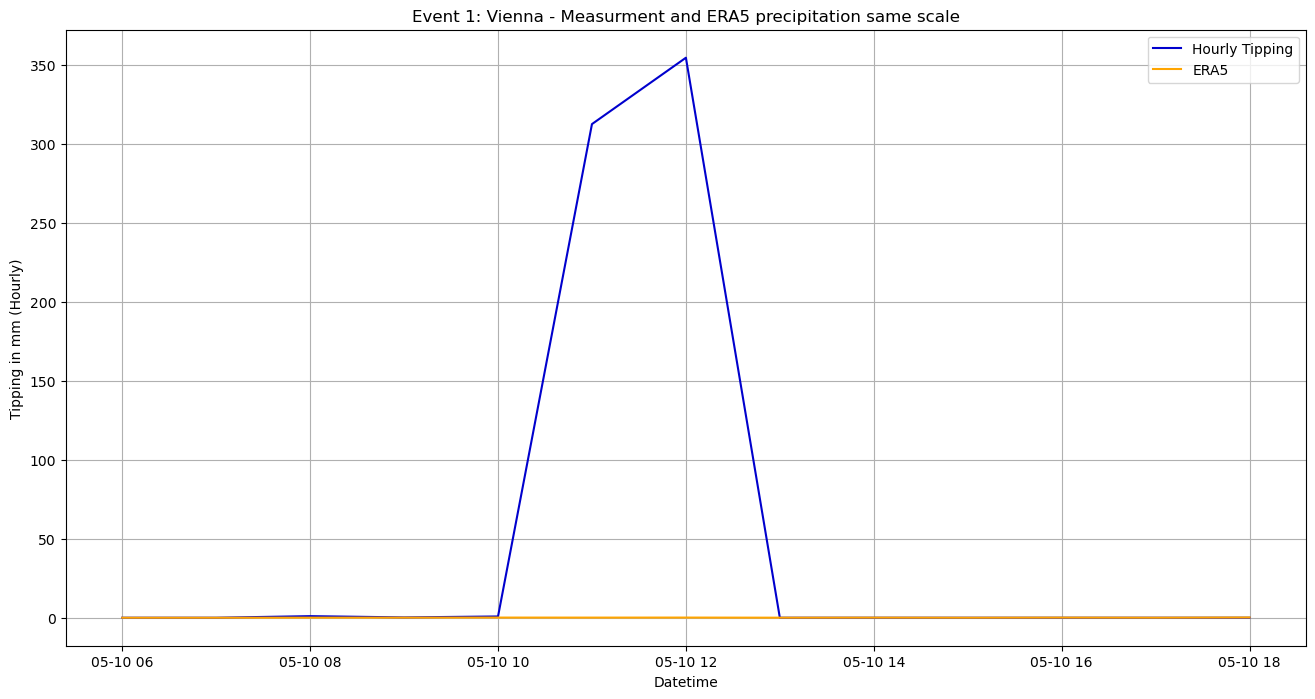

In [67]:
plt.figure(figsize= (16,8)) 
plt.plot(filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
plt.plot(location_tp_pd, color='orange', label="ERA5")
plt.xlabel("Datetime")
plt.ylabel("Tipping in mm (Hourly)")
plt.title("Event 1: Vienna - Measurment and ERA5 precipitation same scale")
plt.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.tick_params(axis='y')
plt.grid(True)

In [69]:
# Event 2

event_2 = pd.Timestamp("2017-10-16 16:00")

# measured 97 l/m2 in 1 h 

# Create a time window of 6 hours before and after the event
time_delta = pd.Timedelta(hours=6)

# Apply the filter using the time window
filtered_df = vienna_hourly_df[(vienna_hourly_df.index >= event_2 - time_delta) & (vienna_hourly_df.index <= event_2 + time_delta)]
filtered_minute_df = vienna_processed_df[(vienna_processed_df.index >= event_2 - time_delta) & (vienna_processed_df.index <= event_2 + time_delta)]


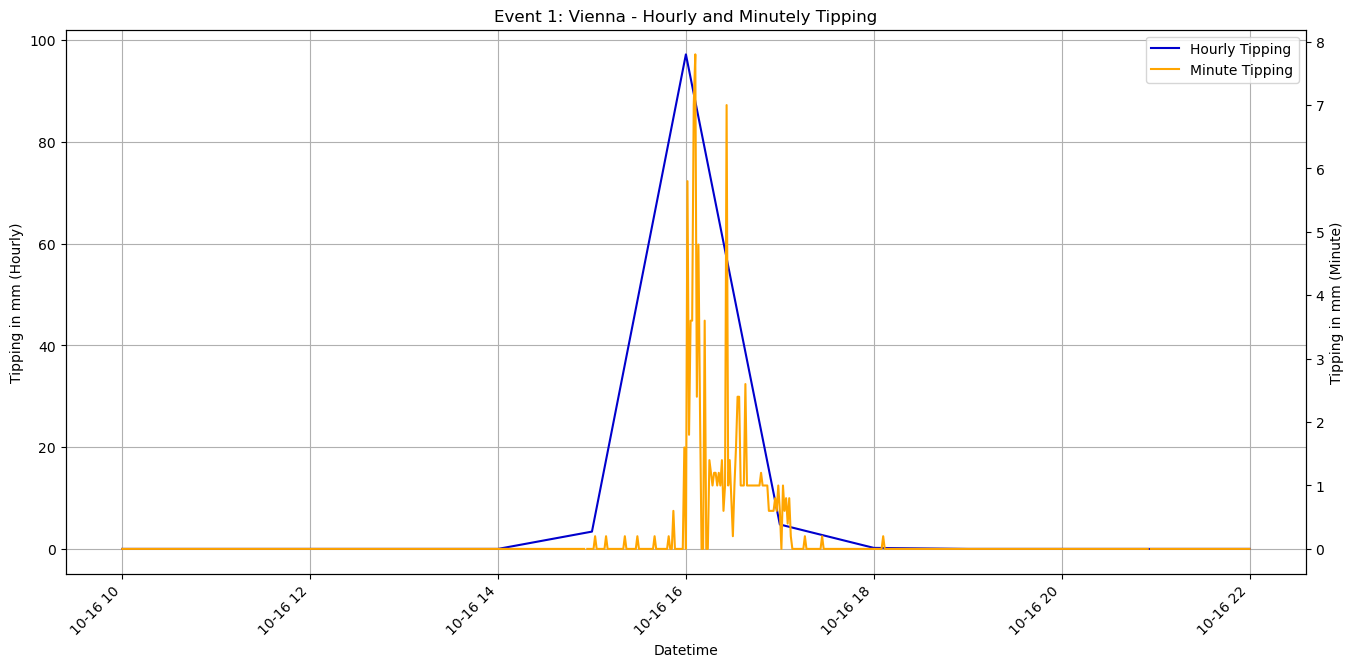

In [70]:
# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(filtered_minute_df["tipping"], color='orange', label="Minute Tipping")
ax2.set_ylabel("Tipping in mm (Minute)")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Hourly and Minutely Tipping")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

In [71]:
location_tp = vienna_er5.tp.sel(lat=48.2303 , lon=16.3609, method='nearest')
location_tp = location_tp.sel(time=slice('2017-10-16 10:00', '2017-10-16 22:00'))


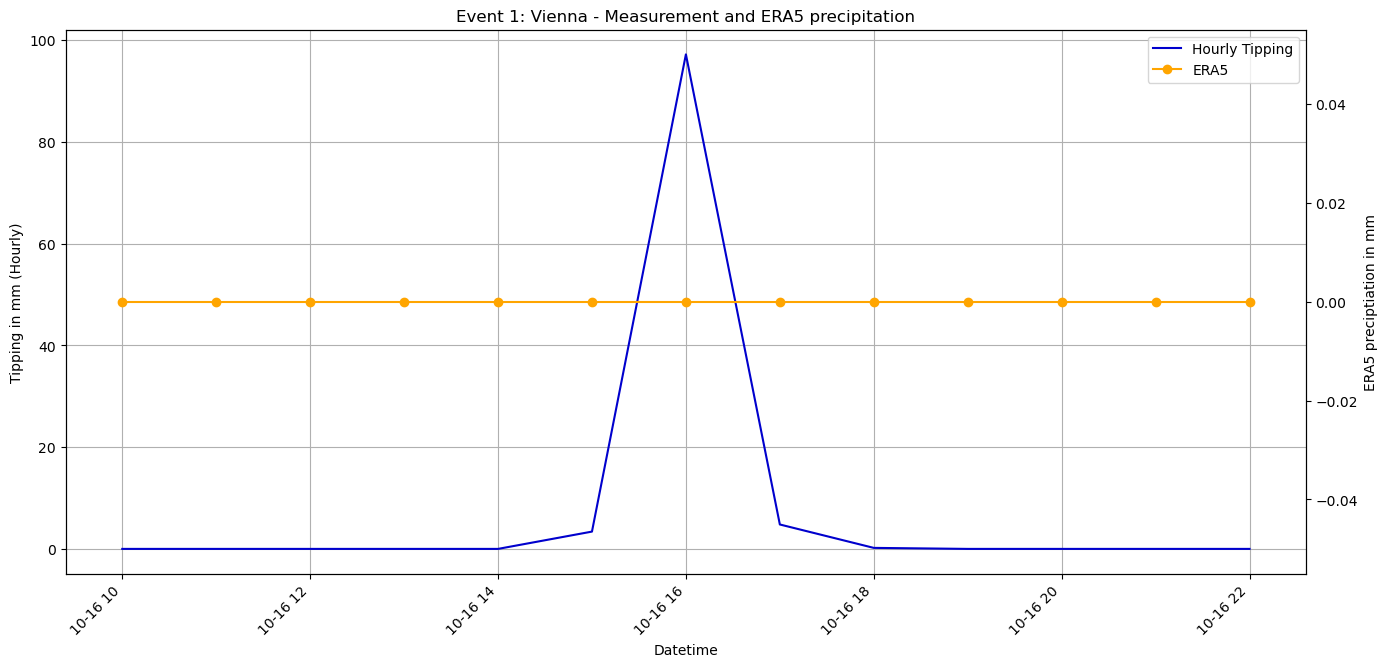

In [72]:
# Convert location_tp to Pandas Series
location_tp_pd = location_tp.to_pandas()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot on the first y-axis (ax1)
ax1.plot(filtered_df.index, filtered_df["tipping"], color='mediumblue', label="Hourly Tipping")
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Tipping in mm (Hourly)")
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot on the second y-axis (ax2)
ax2.plot(location_tp_pd.index, location_tp_pd.values, color='orange', label="ERA5", marker='o')
ax2.set_ylabel("ERA5 preciptiation in mm")
ax2.tick_params(axis='y')

fig.autofmt_xdate(rotation=45)

# Set the title
plt.title("Event 1: Vienna - Measurement and ERA5 precipitation")

# Show legend
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [118]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          era5_ds, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]

    # Extract ERA5 data for the specified location and time window
    era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
    era5_filtered = era5_data.sel(time=slice(start_time, end_time))
    era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2)
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=1.5, marker='o')
        plt.plot(era5_pd.index, era5_pd.values, 
                 color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=1.5, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in mm", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2)
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in mm (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=1.5, marker='o')

        # Create secondary y-axis for ERA5 data
        ax2 = ax1.twinx()
        ax2.plot(era5_pd.index, era5_pd.values, 
                 color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=1.5, marker='x')
        ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in mm", fontsize=12)
        ax2.tick_params(axis='y')

        # Combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()


## Marshall

In [119]:
convert_grib_to_nc("era5_data/era5_marshall_events.nc")


PermissionError: [Errno 13] Permission denied: '/Users/ferdinand/Desktop/MasterThesis/digital-twin-for-weather-station/converted_era5_data/era5_marshall_events.nc'

In [ ]:
marshall_er5 = xr.open_dataset("converted_era5_data/era5_marshall_events.nc")


In [ ]:
print("Highest precip. value in ERA5:",marshall_er5.tp.values.max())
print("Highest temp. value in ERA5:",marshall_er5.t2m.values.max())
print("Highest wind speed value in ERA5:",marshall_er5.wind_speed.values.max())

Highest precip. value in ERA5: 14.425681
Highest temp. value in ERA5: 38.97696
Highest wind speed value in ERA5: 18.766888


In [ ]:
marshall_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
marshall_processed_df.index = pd.to_datetime(marshall_processed_df.index, errors='coerce')

marshall_hourly_df = pd.DataFrame()

for var_name in marshall_processed_df.columns:
    hourly_series = marshall_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    marshall_hourly_df[var_name] = hourly_series

Wind speed:
- 2018-04-17 20:00:00 >15m/s

Precipitation: 
- 20.02.08 16/17 >400l und 100l
- 21.02.19 17 > 60l

Temperature: 
- cold: 22.12.22 13/14/15 <-26°
- hot: 22.07.18 18  >35°

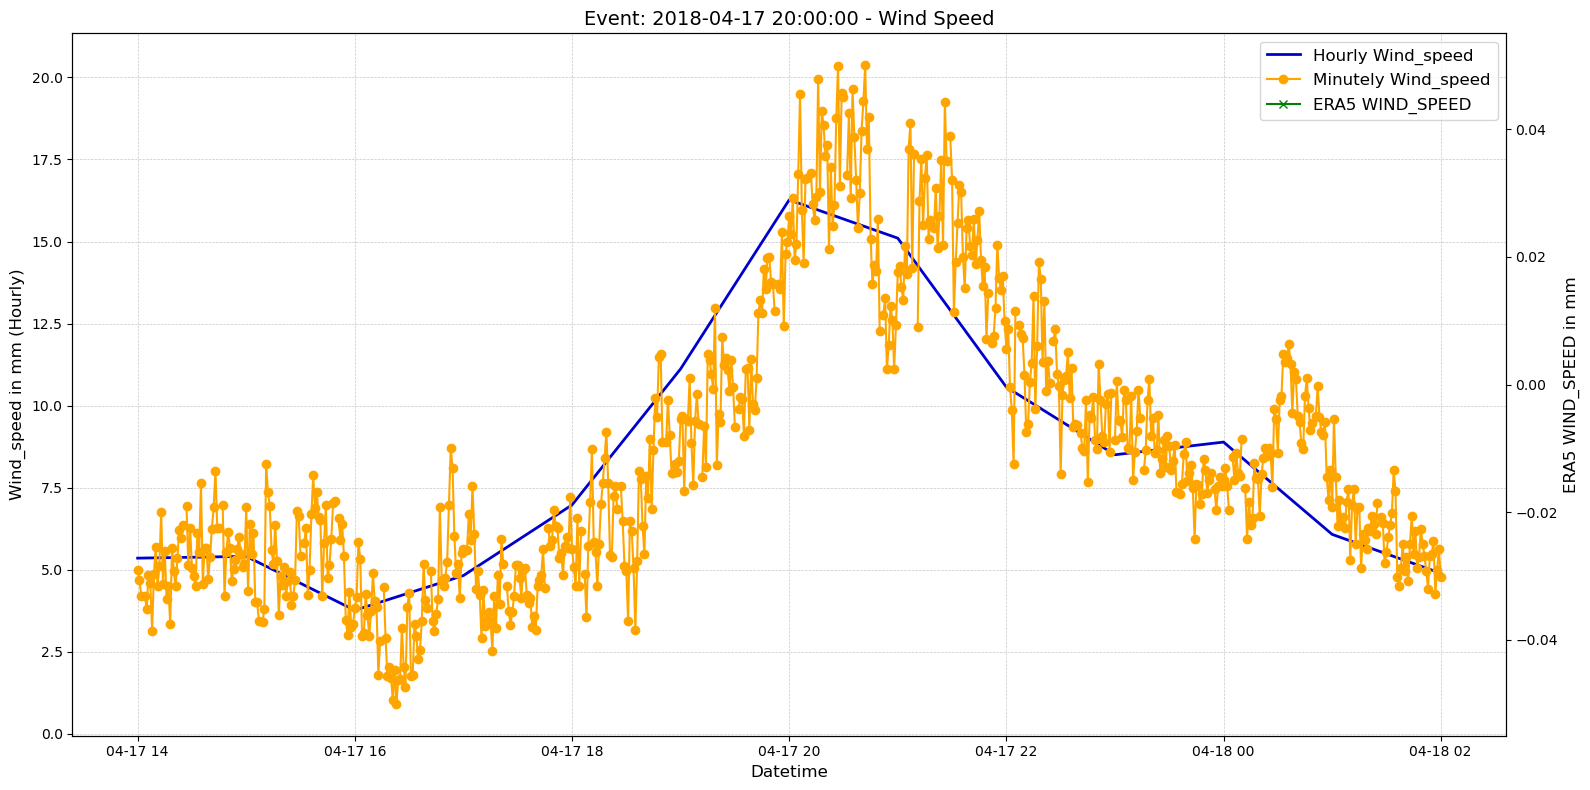

In [120]:
import pandas as pd
import xarray as xr

# Example Event 1
event_1 = pd.Timestamp("2018-04-17 20:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="wind_speed",       # Hourly temperature
    variable_minute="wind_speed",       # Minutely temperature
    era5_variable="wind_speed",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Wind Speed",
    save_fig=False
)



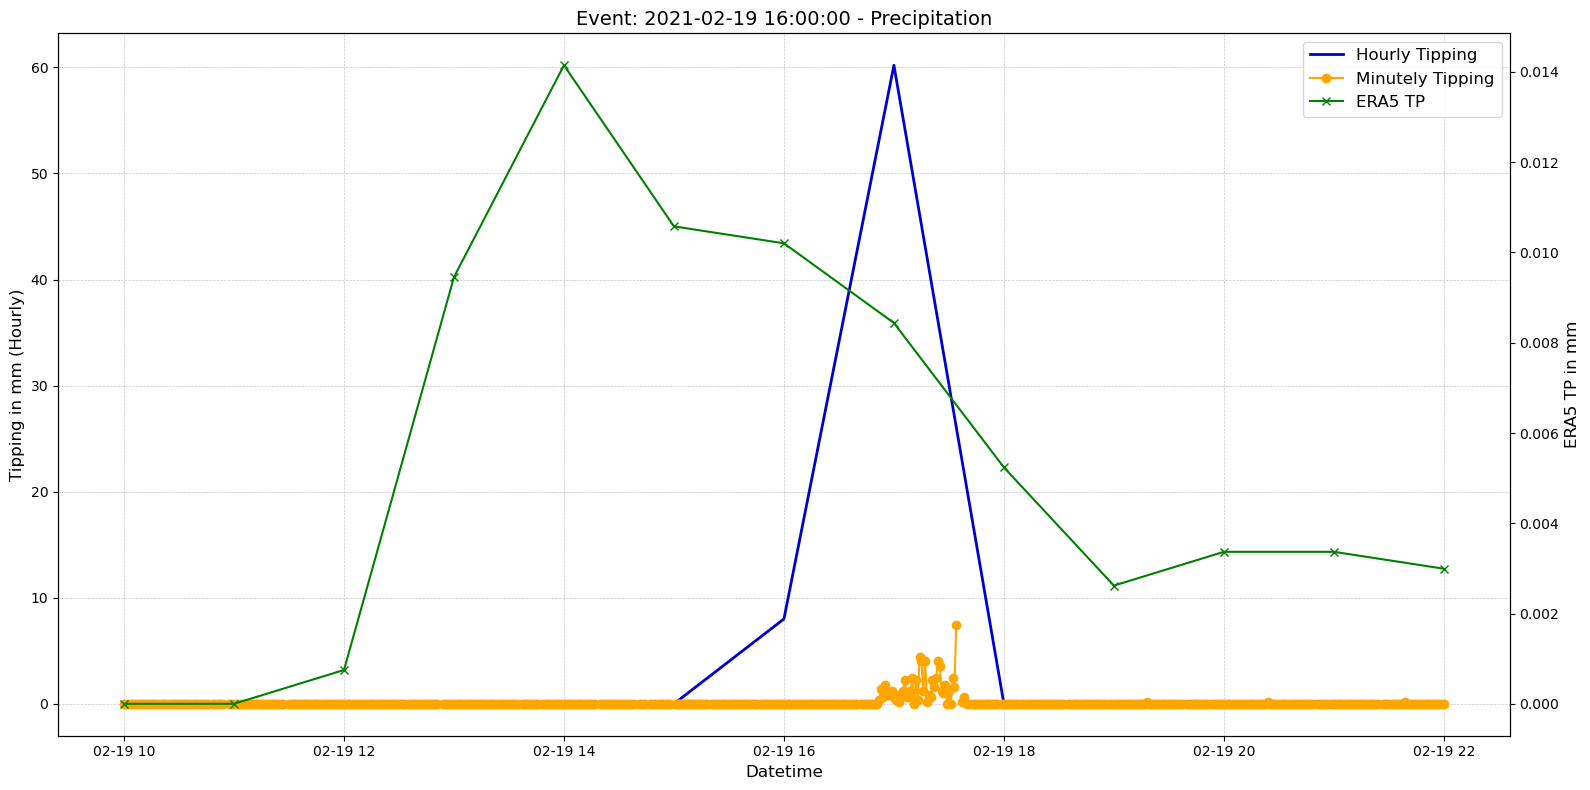

In [121]:
# Example Event 1
event_1 = pd.Timestamp("2021-02-19 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation",
    save_fig=False
)


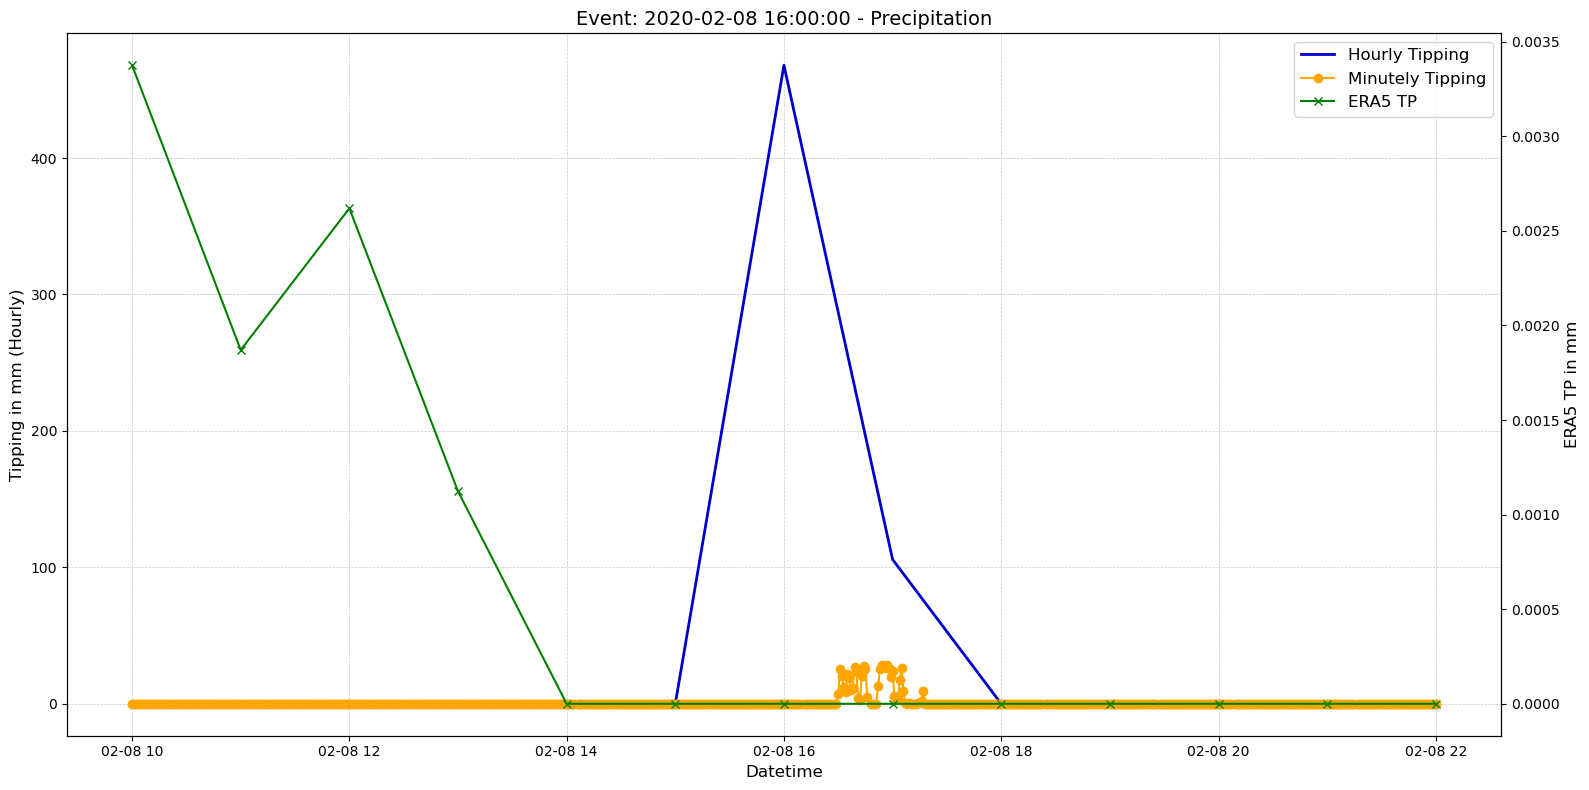

In [122]:
# Example Event 1
event_1 = pd.Timestamp("2020-02-08 16:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=False,
    title_suffix="Precipitation",
    save_fig=False
)


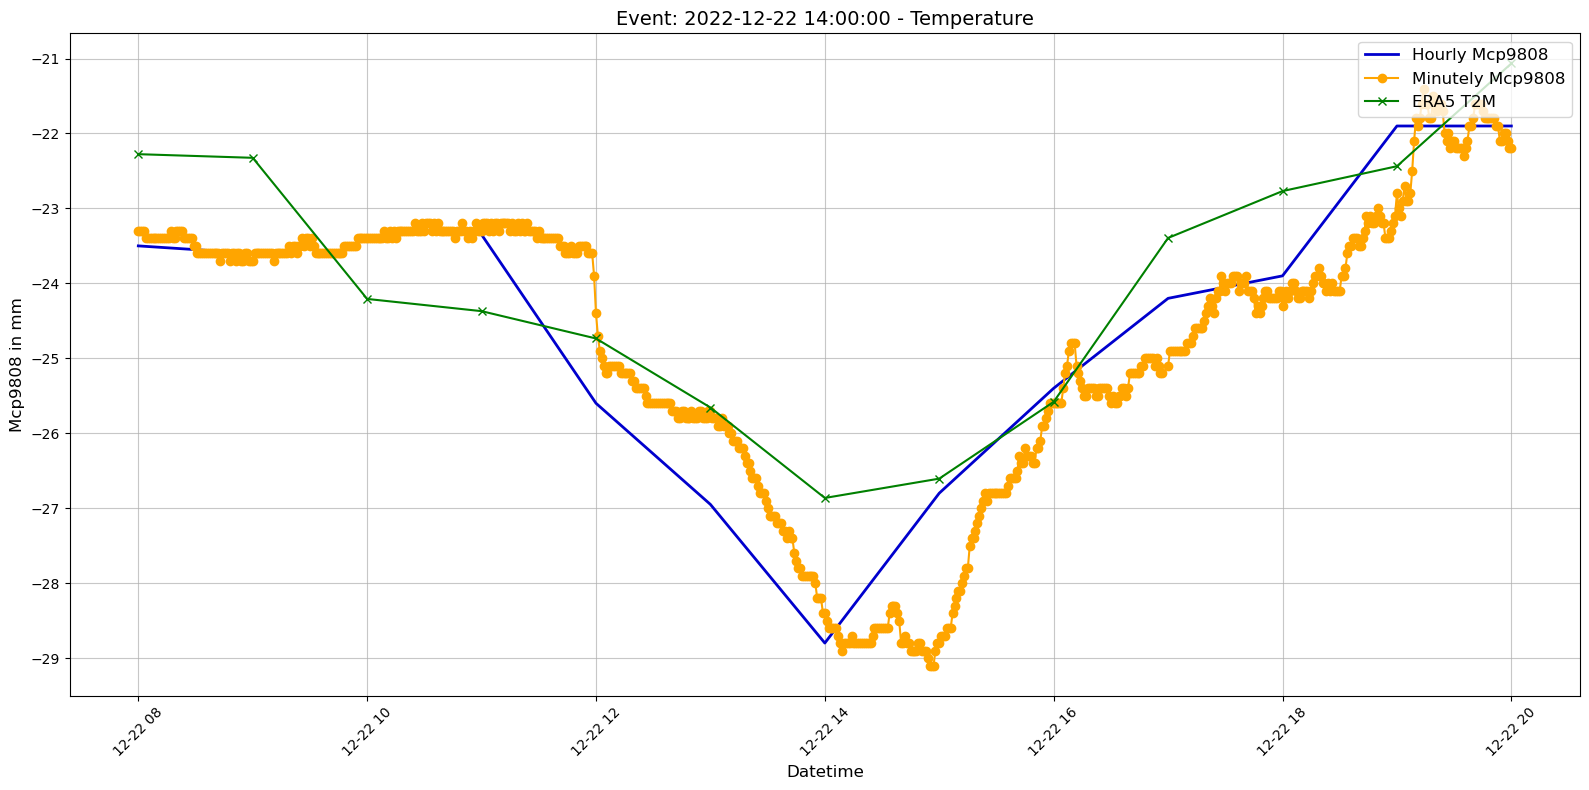

In [123]:
# Example Event 1
event_1 = pd.Timestamp("2022-12-22 14:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Temperature",
    save_fig=False
)

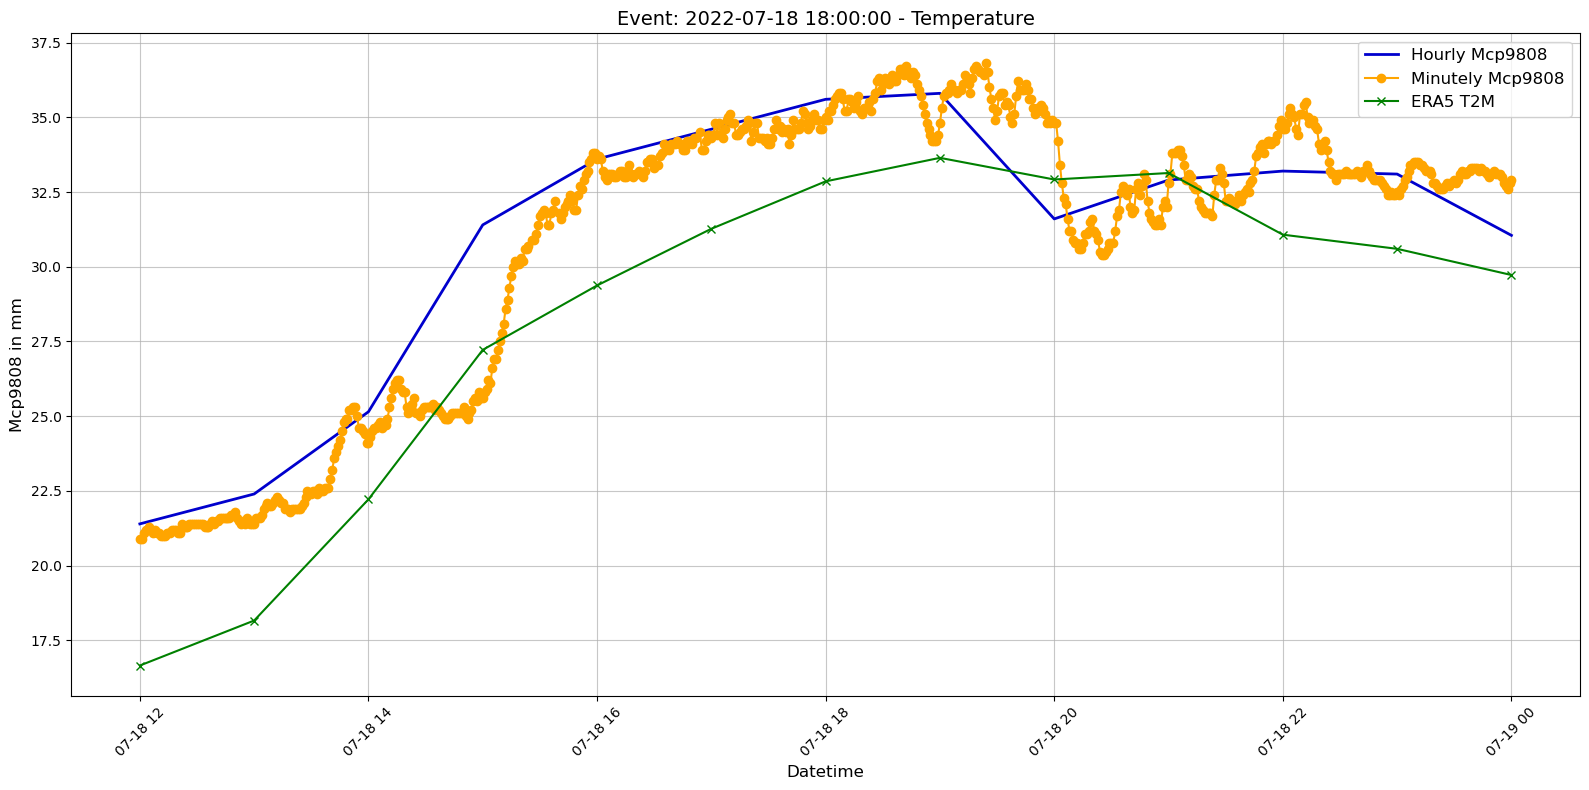

In [124]:
# Example Event 1
event_1 = pd.Timestamp("2022-07-18 18:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    era5_ds=marshall_er5,
    variable_hourly="mcp9808",       # Hourly temperature
    variable_minute="mcp9808",       # Minutely temperature
    era5_variable="t2m",              # ERA5 2-meter temperature
    lat=39.9496 ,
    lon=-105.196,
    time_window=pd.Timedelta(hours=6),
    same_y_axis=True,
    title_suffix="Temperature",
    save_fig=False
)